### Example of using the Bayesian optimisation package in 1D. This script utilises batch sampling, but not bounds reduction or sub-batch sampling.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as con
import sys
import os

sys.path.append('..')
import BOPackage

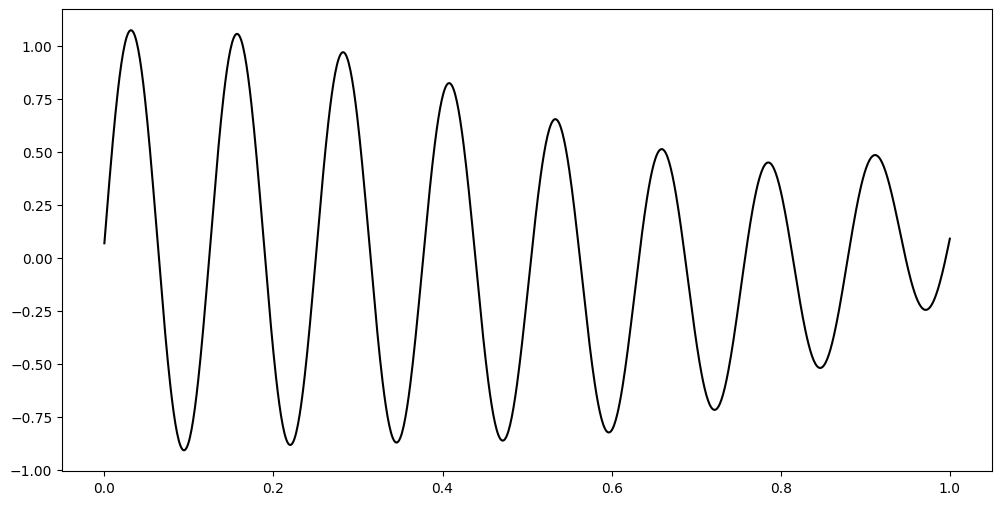

In [23]:
"""
Define the objective function.
"""

def ObjectiveFunction(x):
    return np.sin(50*x) * np.exp(-x**2) + 0.5 * np.cos(5*x) * np.exp(-0.5*(x-2)**2) + 0.1*x


X = np.linspace(0, 1, 1001, endpoint=True).reshape(1001, 1)

plt.figure(figsize=(12, 6))

plt.plot(X[:, 0], ObjectiveFunction(X), color='k')

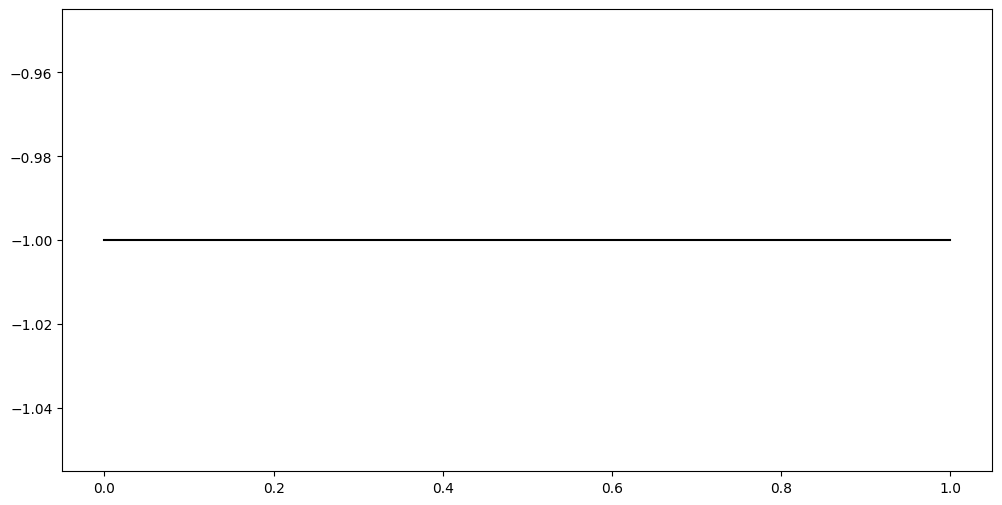

In [24]:
def PriorMeanFunction(X):
    return - np.ones(len(X)).reshape(len(X), 1)

plt.figure(figsize=(12, 6))

plt.plot(X[:, 0], PriorMeanFunction(X), color='k')

In [25]:
"""
Configure the optimiser.
"""
PriorMean = PriorMeanFunction
Kernel = BOPackage.RBF_Kernel_CPU
# Kernel = BOPackage.MaternKernel
length_scale = 0.5             # Note, the length scale is the length scale after standardisation (setting the mean to 0 and standard deviation to 1)

AcquisitionFunction = BOPackage.UpperConfidenceBound
max_kappa = 100                  # Maximum kappa value used in the acquisition function for the batch
min_kappa = 0.1                 # Minimum kappa value used in the acquisition function for the batch

bounds = np.array([[0, 1]])
acquisition_samples = 1000        # Number of random points in the domain to calculate the acqusition function value at. The point with the highest acquisition function value will be added to the raw_X for the batch

random_seed = None                # random seed for reproducability if wanted. 

# Create the object
bo = BOPackage.BO(PriorMeanFunction=PriorMean,
                  KernelFunction=Kernel, 
                  length_scale=length_scale, 
                  AcquisitionFunction=AcquisitionFunction, 
                  bounds=bounds, 
                  acquisition_samples=acquisition_samples,
                  random_seed=random_seed)

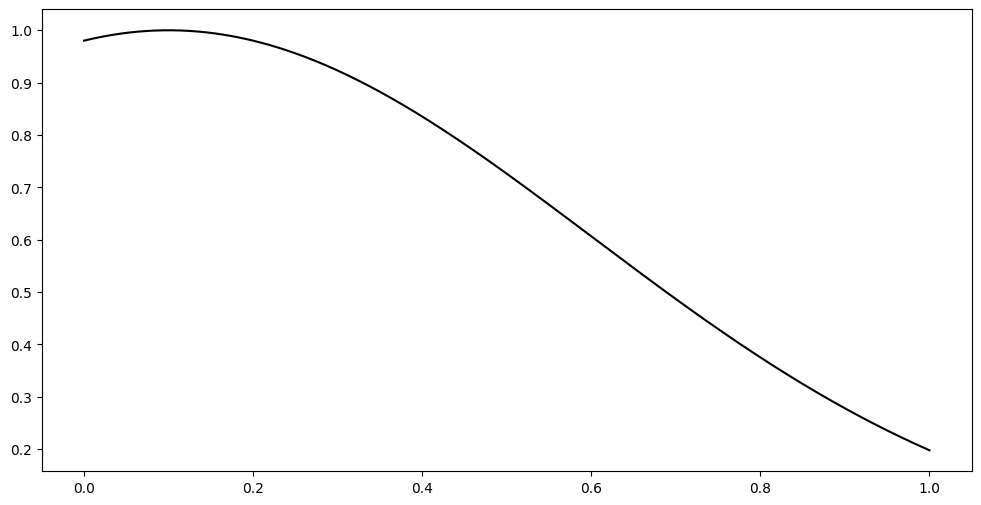

In [26]:
test_X = np.array([[0.1]])
kernel_example = bo.Kernel(test_X, X, length_scales=length_scale)

plt.figure(figsize=(12, 6))

plt.plot(X, kernel_example[0, :], color='k')

In [27]:
"""
Get first random batch and update the optimiser.
"""

raw_X = bo.GetRandomXBatch(batch_size=4)
raw_Y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_Y)

bo.X_data, bo.y_data

(array([[0.4911849 ],
        [0.78628977],
        [0.1218788 ],
        [0.60964896]]),
 array([[-0.50113001],
        [ 0.44846681],
        [-0.10287633],
        [-0.68261794]]))

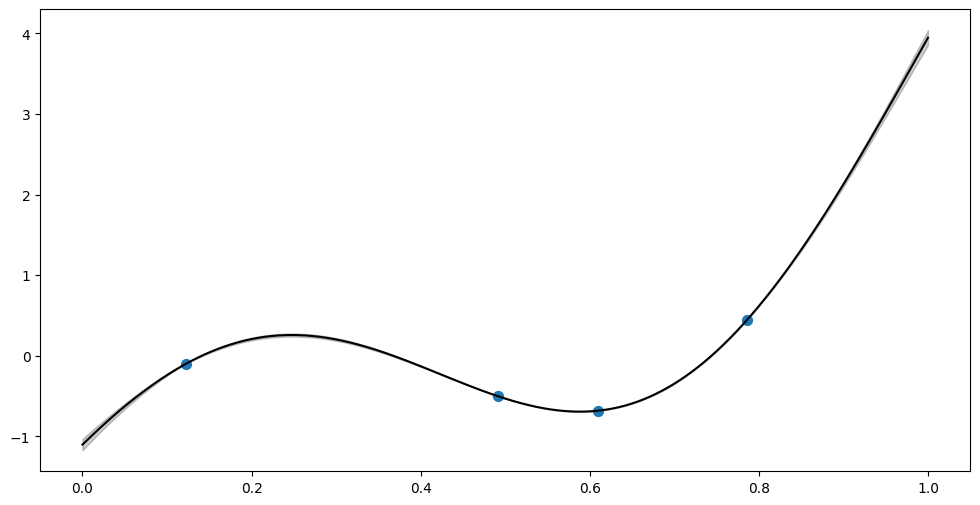

In [28]:
"""
Can then visualise the mean and variance over the parameter
using the true y values.
"""

mean, variance = bo.PredictMeanVariance(X, normalised=False)

plt.figure(figsize=(12, 6))

# # Plot the mean and the confidence interval
plt.plot(X, mean, label='mean', color='k')
plt.fill_between(X[:,0], mean[:,0] - 1.96 * np.sqrt(variance[:,0]), mean[:,0] + 1.96 * np.sqrt(variance[:,0]), color = 'k', alpha=0.2, label = '95% confidence interval')

# Scatter plot of X_data and y_data
plt.scatter(bo.X_data, bo.y_data, s=50)

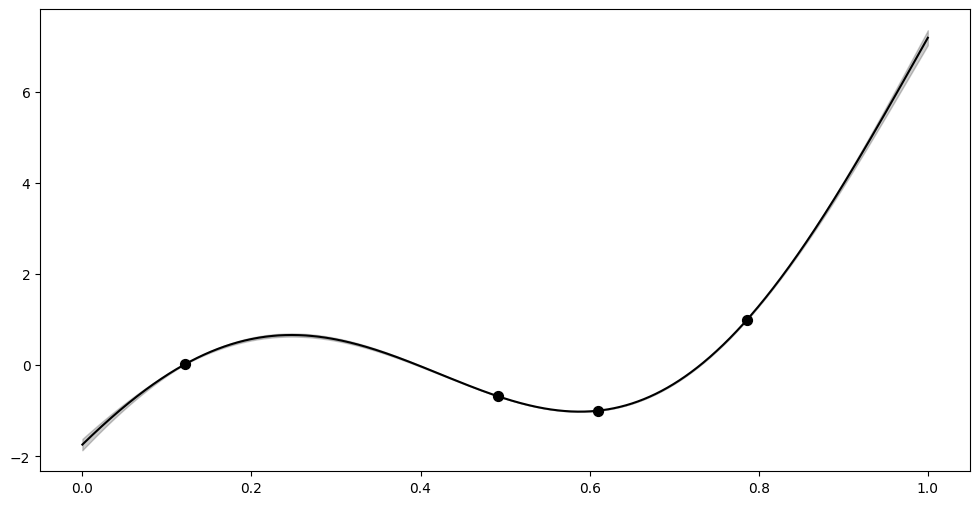

In [29]:
"""
Or can visualise the mean and variance over the parameter
using the normalised y values (which the code uses).
"""

if np.max(bo.y_data) - np.min(bo.y_data) != 0.0:
    normalised_y_data = 2 * (bo.y_data - np.min(bo.y_data)) / (np.max(bo.y_data) - np.min(bo.y_data)) - 1
else:
    normalised_y_data = bo.y_data

if bo.minimise is True:
    normalised_y_data = -normalised_y_data

normalised_mean, normalised_variance = bo.PredictMeanVariance(X, normalised=True)


plt.figure(figsize=(12, 6))

# Plot the mean and the confidence interval
plt.plot(X, normalised_mean, label='mean', color='k')
plt.fill_between(X[:,0], normalised_mean[:,0] - 1.96 * np.sqrt(normalised_variance[:,0]), normalised_mean[:,0] + 1.96 * np.sqrt(normalised_variance[:,0]), color = 'k', alpha=0.2, label = '95% confidence interval')

# Scatter plot of X_data and y_data
plt.scatter(bo.X_data, normalised_y_data, s=50, color='k')

<Figure size 1200x600 with 0 Axes>

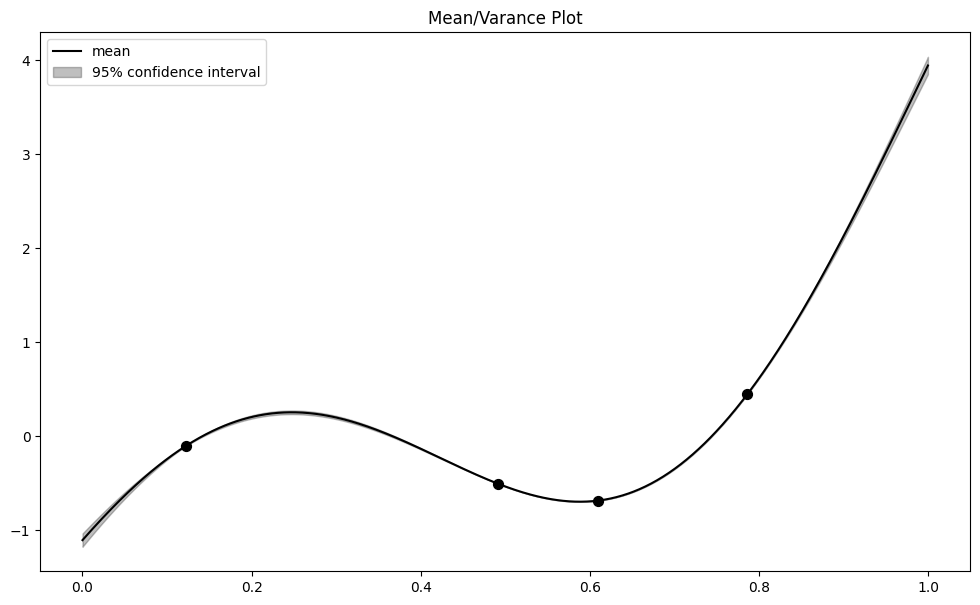

In [30]:
"""
Take a look at the mean and variance of the function now we have some data
using the function defined in the package.
"""

BOPackage.SausagePlot(bo, normalised=False)

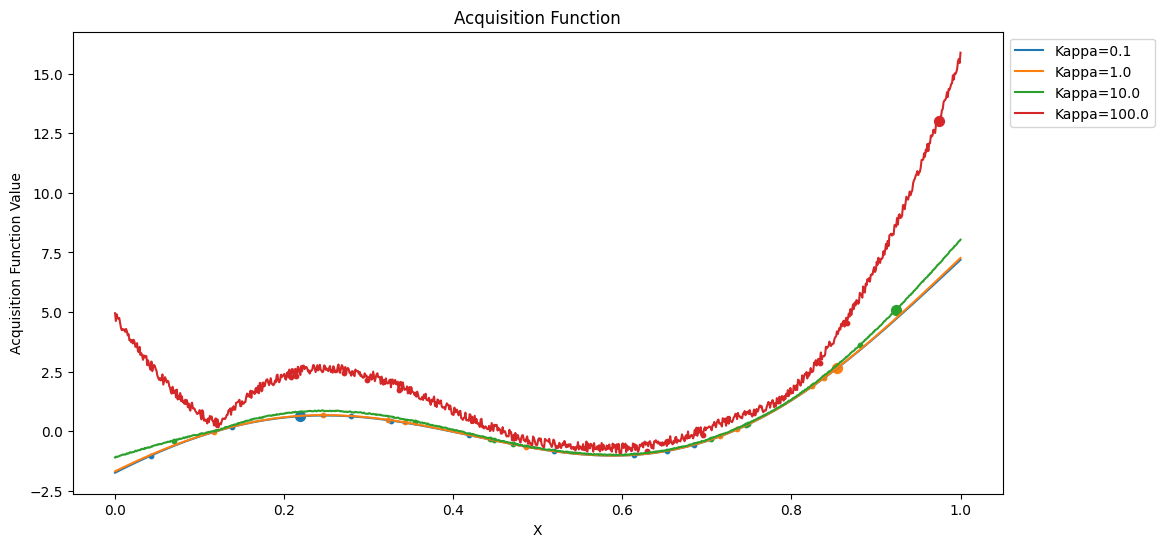

In [31]:
"""
Plot the Acquisition function for a range of kappas and demonstrate how the next point is selected.

'n_sample' random X values are selected and the one which returns the largest acqusition function value
is chosen for each kappa value. Assuming no 'sub batches' are used, there will be 'batch_size' kappa 
values and a point in X will be selected for each kappa value.
"""

raw_X = BOPackage.KappaAcquisitionFunctionPlot(bo, number_kappas=4, number_candidate_points=10, max_kappa=max_kappa, min_kappa=min_kappa)

<Figure size 1200x600 with 0 Axes>

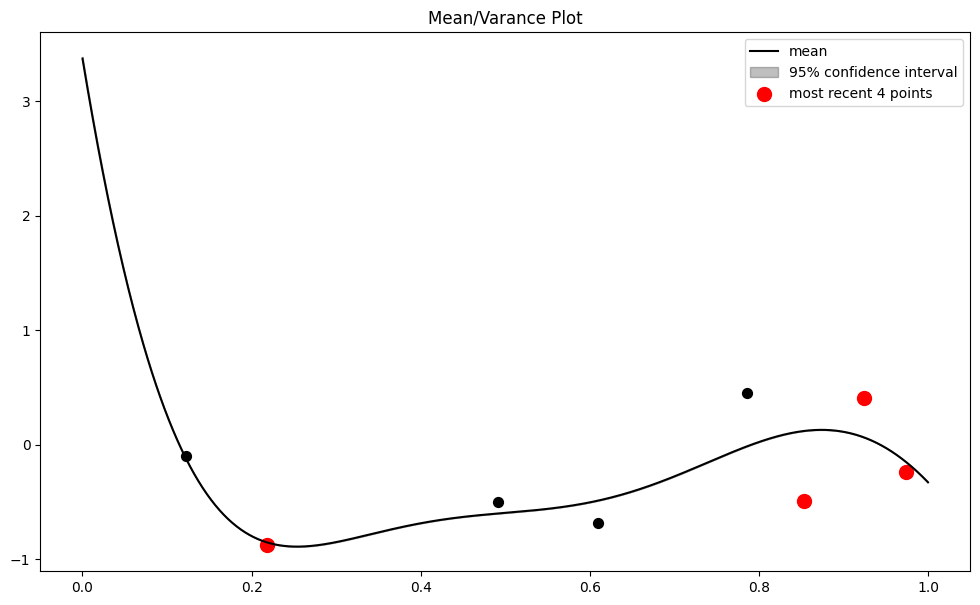

In [32]:
"""
Now select the next batch of X values using the acquisition function (not random) and update the optimiser.
"""

# batch_size = 4
# raw_X = bo.GetNextXBatch(batch_size=batch_size, max_kappa=max_kappa, min_kappa=min_kappa)
raw_Y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_Y)

BOPackage.SausagePlot(bo, highlight_recent=len(raw_X))

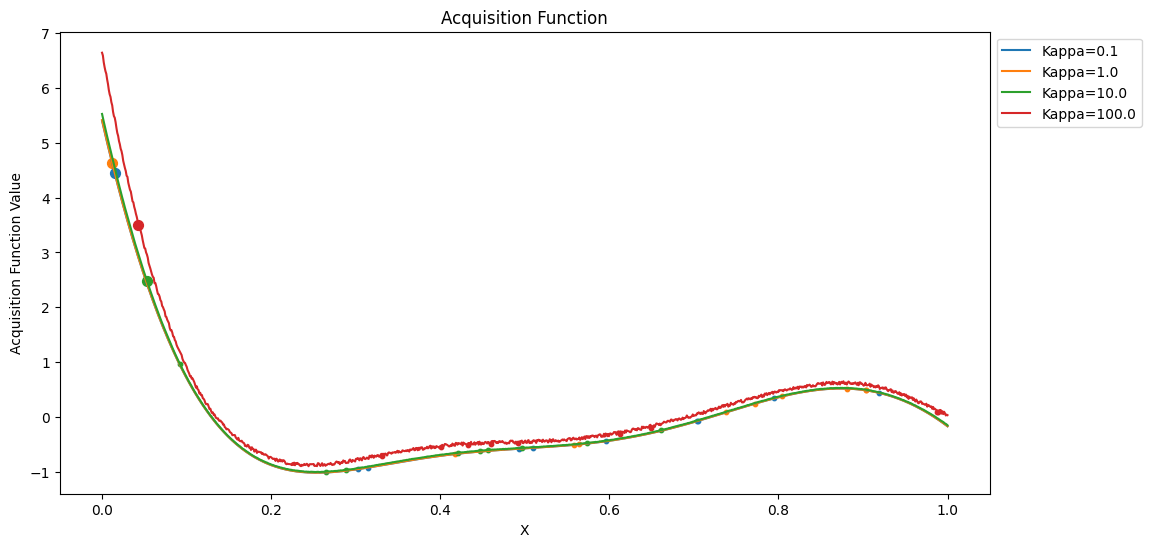

In [33]:
"""
Again lets looks at the acquisition function and how our next X set is selected.
"""
raw_X = BOPackage.KappaAcquisitionFunctionPlot(bo, number_kappas=4, number_candidate_points=10, max_kappa=max_kappa, min_kappa=min_kappa)

<Figure size 1200x600 with 0 Axes>

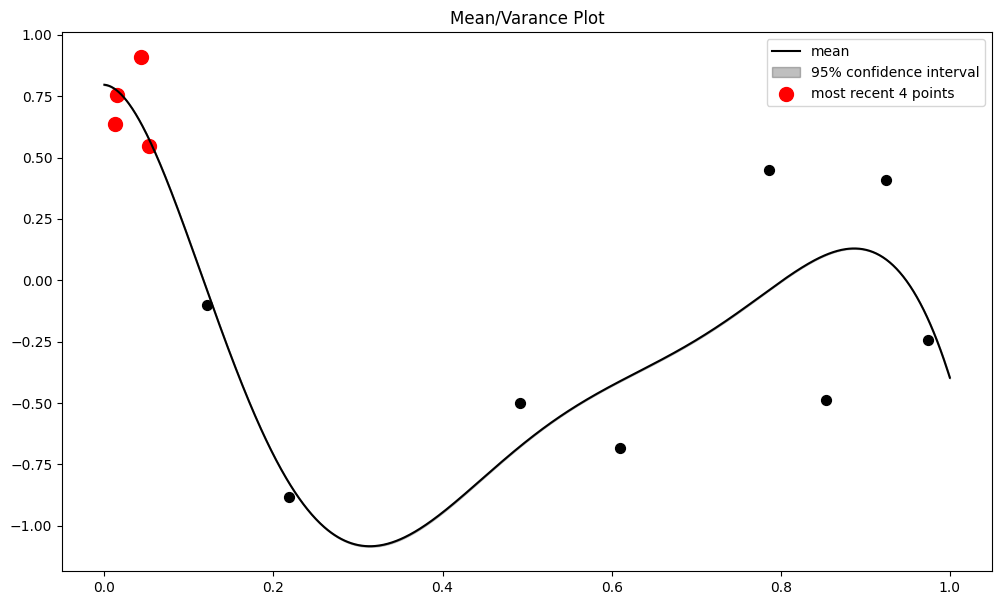

In [34]:
"""
Final example of doing this again.
"""
# batch_size = 4

# raw_X = bo.GetNextXBatch(batch_size=4, max_kappa=max_kappa, min_kappa=min_kappa)
raw_Y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_Y)

BOPackage.SausagePlot(bo, highlight_recent=len(raw_X))

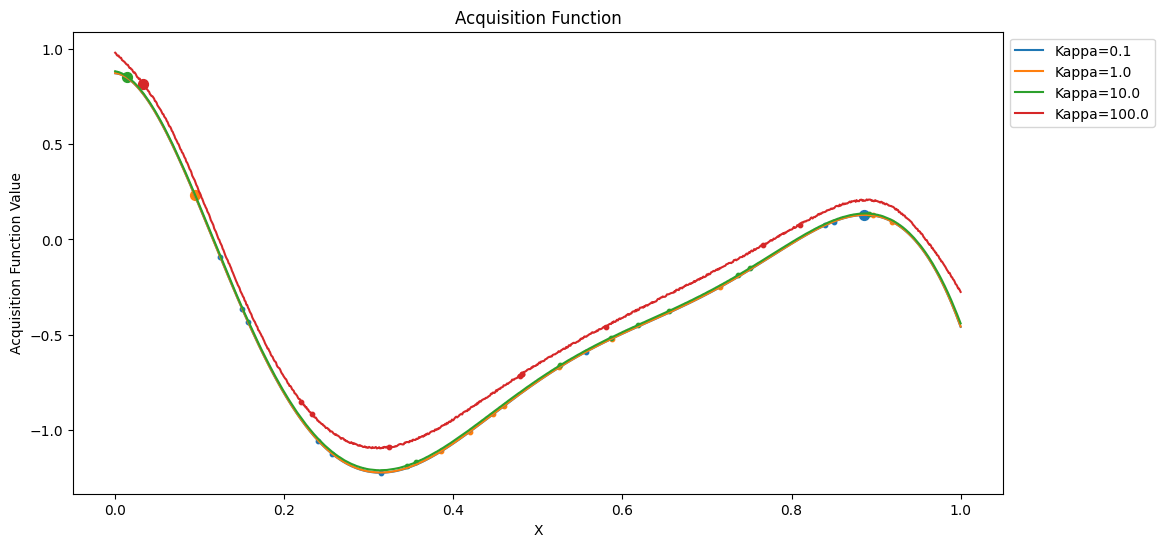

In [35]:
raw_X = BOPackage.KappaAcquisitionFunctionPlot(bo, number_kappas=4, number_candidate_points=10, max_kappa=max_kappa, min_kappa=min_kappa)

<Figure size 1200x600 with 0 Axes>

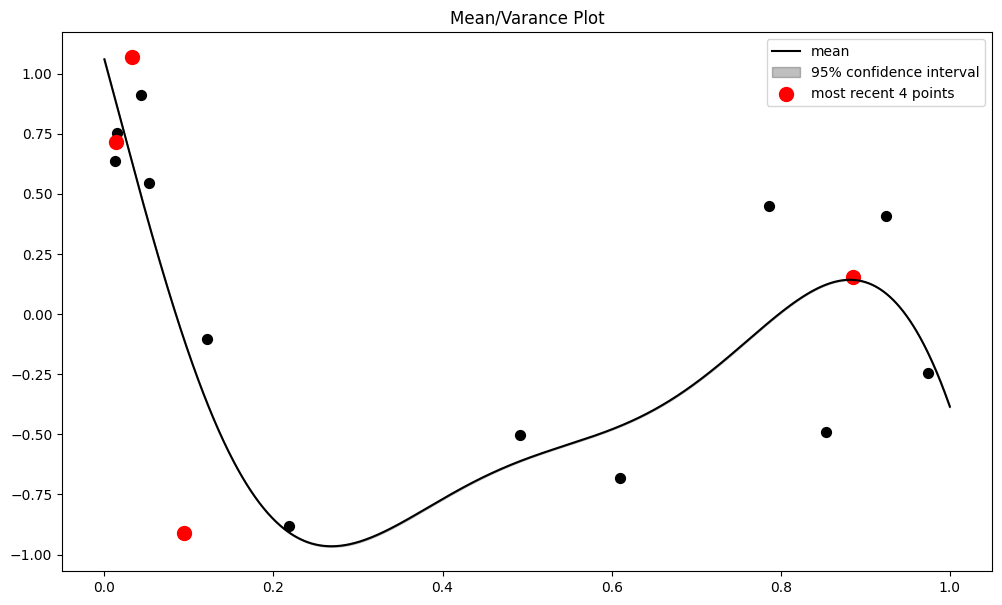

In [36]:
"""
Final example of doing this again.
"""
# batch_size = 4

# raw_X = bo.GetNextXBatch(batch_size=4, max_kappa=max_kappa, min_kappa=min_kappa)
raw_Y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_Y)

BOPackage.SausagePlot(bo, highlight_recent=len(raw_X))

<Figure size 1200x600 with 0 Axes>

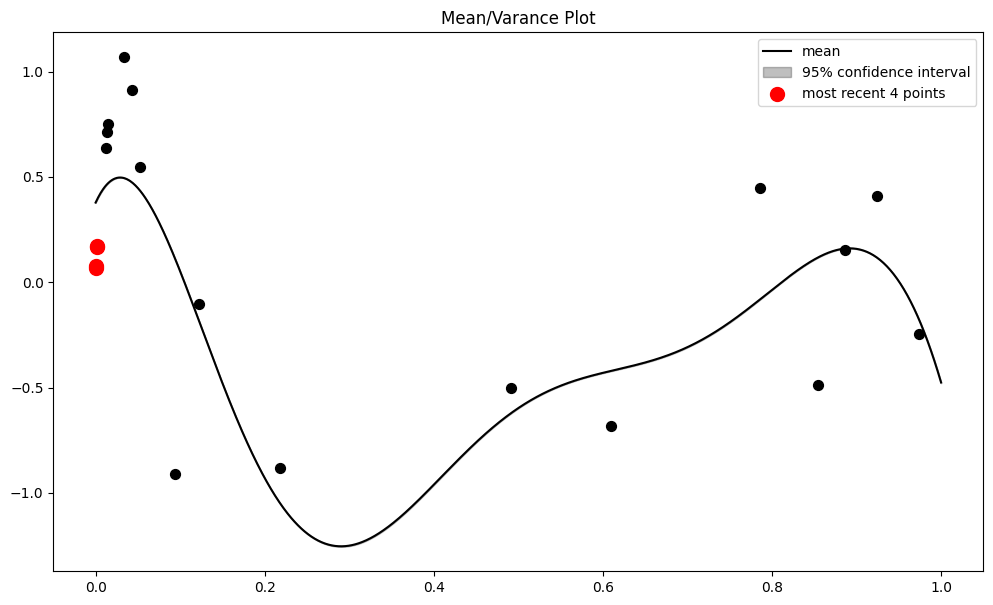

In [37]:
"""
Final example of doing this again.
"""
batch_size = 4

raw_X = bo.GetNextXBatch(batch_size=4, max_kappa=max_kappa, min_kappa=min_kappa, sub_batch_size=2)
raw_Y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_Y)

BOPackage.SausagePlot(bo, highlight_recent=len(raw_X))

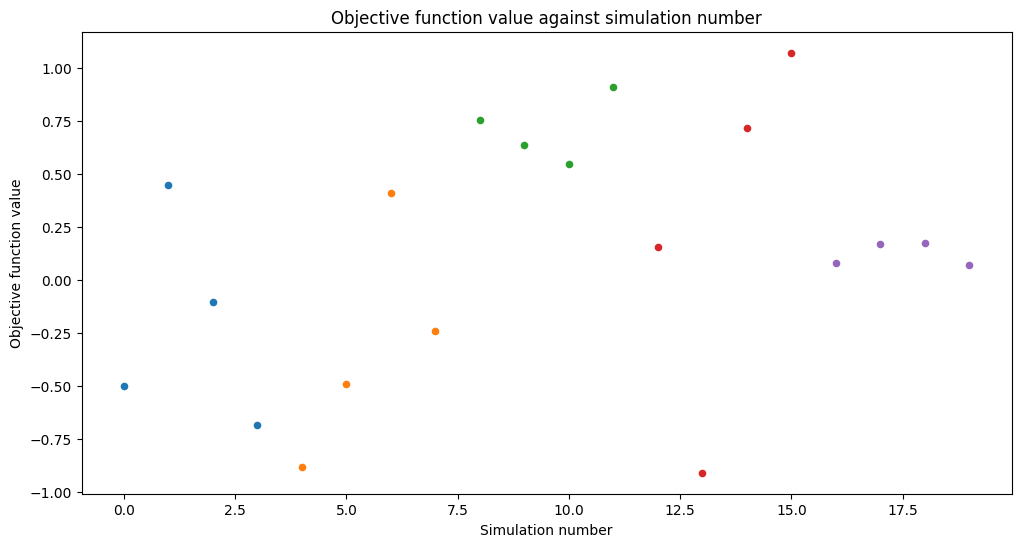

In [38]:
BOPackage.PlotData(bo)

0.039560500000000005


(-10.0, 5.0)

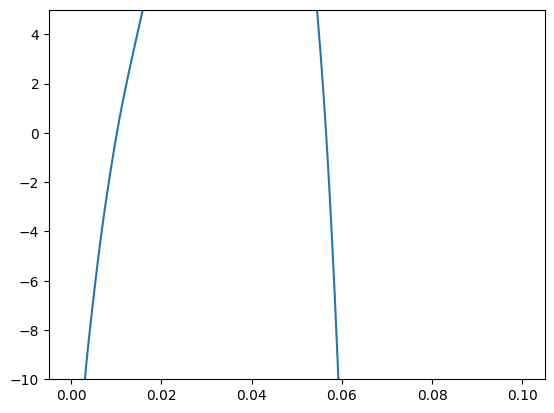

In [39]:
LML_array = []
length_scales = np.linspace(0.0001, 0.1, 1001)
for l in length_scales:
    Kernel = BOPackage.RBF_Kernel_CPU
    result = BOPackage.log_marginal_likelihood(bo.X_data, bo.y_data, Kernel, l)[0][0]
    # print(l, result)
    LML_array.append(result)

print(length_scales[np.argmax(LML_array)])
plt.plot(length_scales, np.array(LML_array))
plt.ylim(-10, 5)